In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label


np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20

def plot_img_label(img, lbl, cls_dict, n_classes=4, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)
    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i
    class_img = lbl_cmap_classes(res)
    class_img[...,:3][res==0] = 0 
    class_img[...,-1][res==0] = 1
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(class_img)
    ac.imshow(render_label(res, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap_classes))
    ac.set_title(cls_title)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\DELL\anaconda3\envs\GPU-TF\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
transport.py (219): Blowfish has been deprecated


In [2]:
# set the number of object classes
n_classes = 4

In [3]:
# generate synthetic samples of 2D images, label masks, and class dicts 

def generate_sample(n=256):
    from scipy.ndimage.morphology import distance_transform_edt
    from skimage.segmentation import watershed, relabel_sequential 
    from skimage.morphology import disk, binary_erosion, binary_closing
    from scipy import ndimage as ndi
    m = np.random.randint(10,30)
    center = tuple(np.random.randint(0,n,(2,m)))
    markers = np.zeros((n,n),np.uint16)
    markers[center] = np.random.permutation(np.arange(1,m+1))
    
    dist = distance_transform_edt(1-1*(markers>0)) + 4*ndi.zoom(np.random.uniform(0,1,(n//16,n//16)), (16,16), order=1)
    dist *= np.random.uniform(1,2)
    y = watershed(dist, markers, mask=np.exp(-.1*dist)>.1)
        
    y = relabel_sequential(np.max(np.stack([i*binary_closing(y==i,disk(3)) for i in np.unique(y[y>0])],axis=0),axis=0))[0]

    ind = np.arange(1,y.max()+1)
    np.random.shuffle(ind)
    c1, c2 = ind[:len(ind)//2], ind[len(ind)//2:]
    m1 = np.isin(y,c1)
    m2 = np.isin(y,c2)    
    
    x =  ndi.filters.gaussian_filter((y>0).astype(np.float32),2)
        
    noise1 = ndi.zoom(np.random.uniform(0,1,(n//4,n//4)), (4,4), order=3)
    noise2 = ndi.zoom(np.random.uniform(0,1,(n//16,n//16)), (16,16), order=3)
    x[m1] = .2*(1+np.sin(y[m1]))+noise1[m1]
    x[m2] = .2*(1+np.sin(y[m2]))+noise2[m2]
    x = ndi.filters.gaussian_filter(x,1)+2*ndi.filters.gaussian_filter(x,20)
    gain = 100 
    x = np.random.poisson((1+gain*x).astype(int))/gain
    x += .08*np.random.normal(0,1,x.shape)
    cls = dict((i,1 if i in c1 else 2) for i in range(1,m+1))
    return x, y, cls

Generate a synthetic training set of 100 random images, label masks, and class dictionaries.

In [4]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

def make_image(folder_paths, height, width):
    
    new_image = np.zeros((height, width), dtype=np.uint8)
    
    my_dict = {}

    class_name_reco = {
        'Blue': 1,
        'Green': 2,
        'Yellow': 3,
        'Red': 4
    }
    for i, path in enumerate(folder_paths):
        
        class_name= path.split('\\')[-1].split('_')[-2]
        reference_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        reference_image = cv2.resize(reference_image, (width, height))
        new_image[reference_image > 0 ] = i+1
        my_dict[i+1] = class_name_reco[class_name]
        
        
    return new_image, my_dict

    

X=[]
Y=[]
C=[]
for path in tqdm(os.listdir('data/Traning/')):
    roi=io.imread(glob.glob('data/Traning/'+path+'/image/*.png')[0])
    #height, width, _ = roi.shape
    height, width, _ = [256,256,3]
    roi = transform.resize(roi, (height, width))
    
    folder_paths= glob.glob('data/Traning/'+path+'/color_masks/*.png')
    one_image, my_dict=make_image(folder_paths, height, width)
    
    X.append(roi)
    Y.append(one_image)
    C.append(my_dict)
    
    

X_test=[]
Y_test=[]
C_test=[]
for path in tqdm(os.listdir(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing')):
    roi=io.imread(glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/image/*.png')[0])
    height, width, _ = roi.shape
    #height, width, _ = [512,512,3]
    roi = transform.resize(roi, (height, width))
    
    folder_paths= glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/color_masks/*.png')
    one_image, my_dict=make_image(folder_paths, height, width)
    
    X_test.append(roi)
    Y_test.append(one_image)
    C_test.append(my_dict)

100%|██████████| 44/44 [00:08<00:00,  5.32it/s]


In [5]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
print(n_channel)

3


Split into train and validation datasets.

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.10 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val, C_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val] , [C[i] for i in ind_val]
X_trn, Y_trn, C_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train],  [C[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 1265
- training:       1139
- validation:     126


Training data consists of pairs of input image and label instances.

(<Axes: title={'center': 'image'}>,
 <Axes: title={'center': 'label'}>,
 <Axes: title={'center': 'classes'}>)

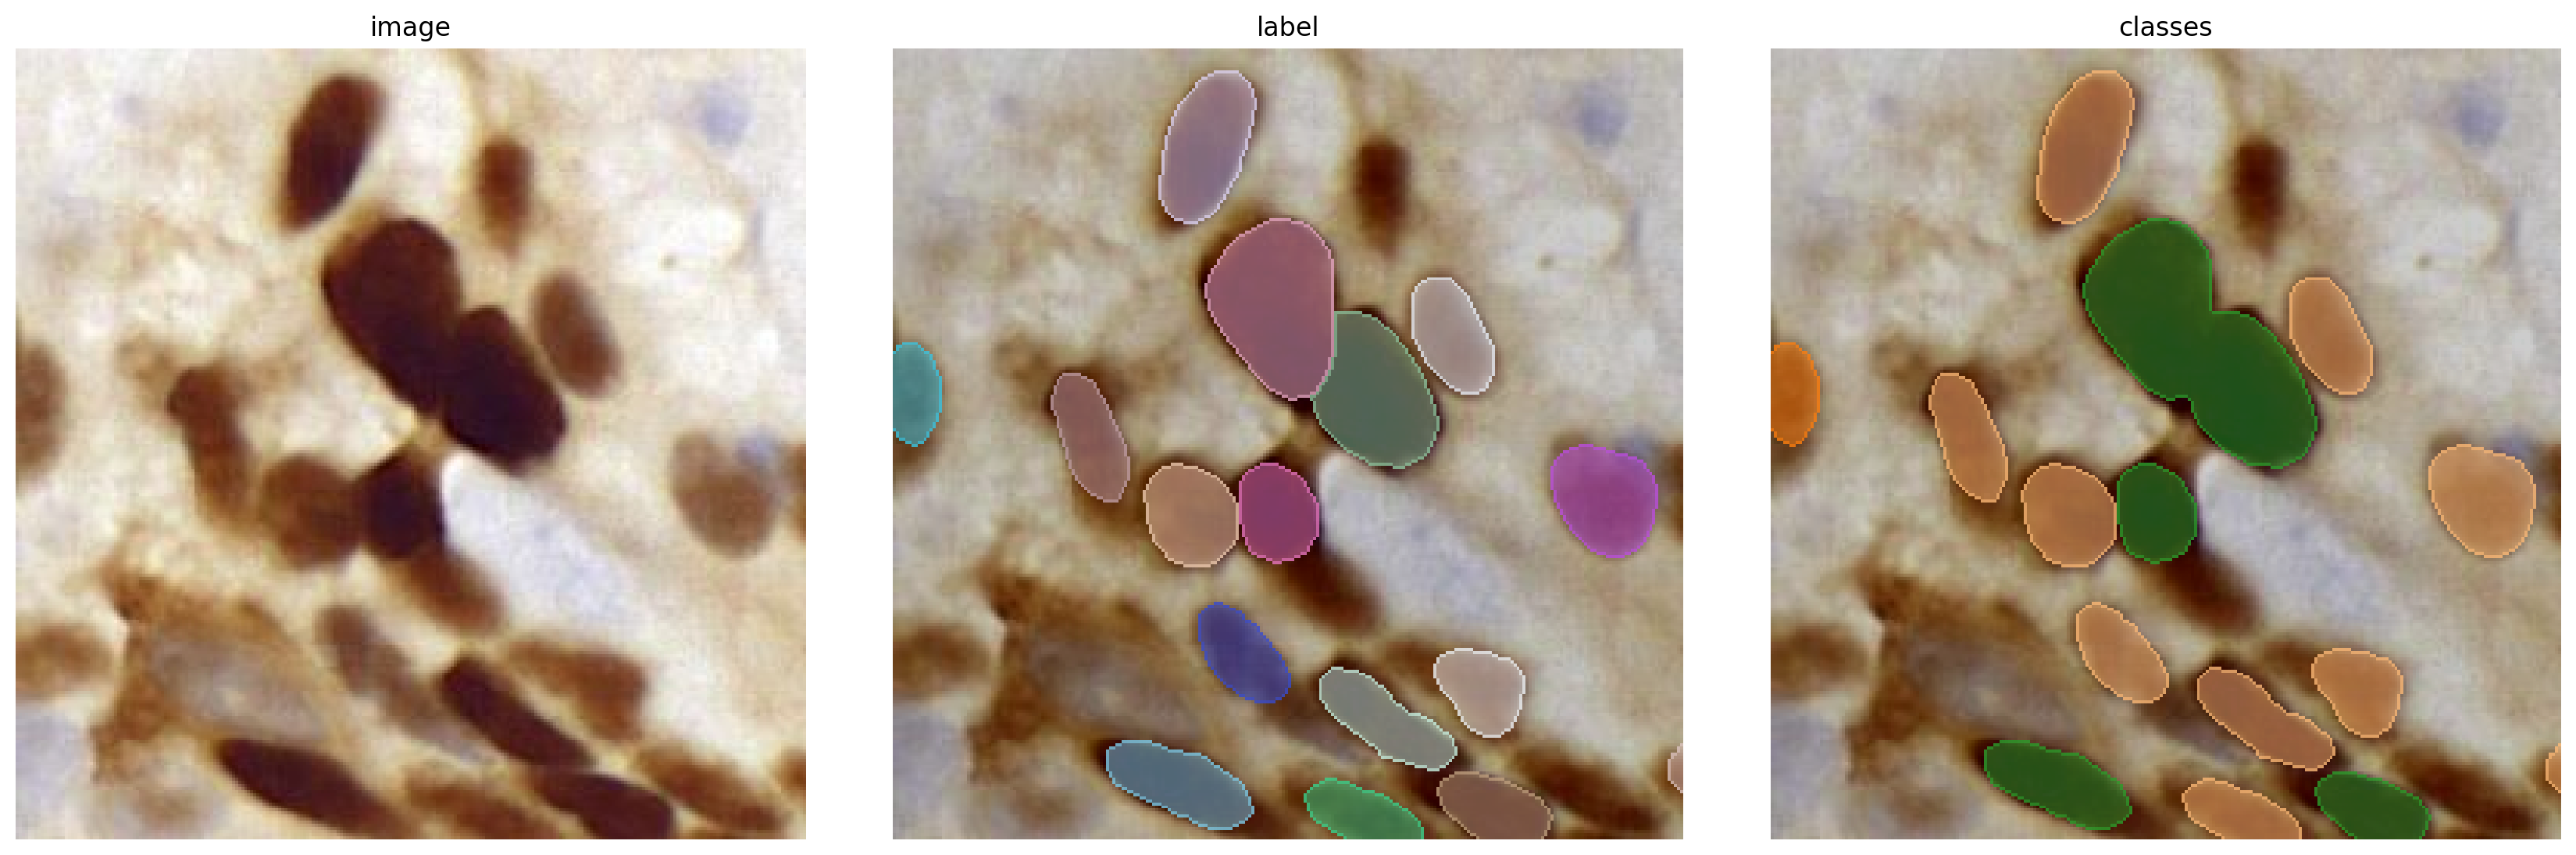

In [7]:
valuesss=95
plot_img_label(X_trn[valuesss],Y_trn[valuesss], C_trn[valuesss])

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [8]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

### Multi-class model

* Set the `n_classes` variable to the number of object classes in the `Config` object.
* Set the `classes` variable in `model.train` to a list of class dictionaries for every training image/label pair.

In [9]:
# 32 is a good default choice
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    n_classes    = n_classes,
    train_steps_per_epoch=1024,
    train_batch_size=1,
#     train_patch_size= (512, 512),
#     net_input_shape= (256, 256, 3),
#     net_mask_shape= (512, 512, 1)
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=4, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2, 1), train_class_weights=(1, 1, 1, 1, 1), train_epochs=400, train_steps_per_epoch=1024, train_learning_rate=0.0003, train_batch_size=1, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_de

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': 4,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2, 1),
 'train_class_weights': (1, 1, 1, 1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 1024,
 'train_learning_rate'

In [10]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)
    # alternatively, adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    # limit_gpu_memory(0.8)    

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [11]:
model = StarDist2D(conf, name='segnet_multiclass_ai4dp', basedir='models')

base_model.py (149): output path for model already exists, files may be overwritten: C:\Users\DELL\Desktop\Final Work StarDist\StarDist\models\segnet_multiclass_ai4dp


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Jahid-GPU
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                    

 batch_normalization_5 (BatchNo  (None, None, None,   1024       ['conv2d_7[0][0]']               
 rmalization)                   256)                                                              
                                                                                                  
 activation_5 (Activation)      (None, None, None,   0           ['batch_normalization_5[0][0]']  
                                256)                                                              
                                                                                                  
 conv2d_8 (Conv2D)              (None, None, None,   590080      ['activation_5[0][0]']           
                                256)                                                              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, None, None,   1024       ['conv2d_8[0][0]']               
 rmalizati

                                                                                                  
 up_sampling2d (UpSampling2D)   (None, None, None,   0           ['max_pooling_with_argmax2d_4[0][
                                512)                             0]']                             
                                                                                                  
 conv2d_15 (Conv2D)             (None, None, None,   2359808     ['up_sampling2d[0][0]']          
                                512)                                                              
                                                                                                  
 batch_normalization_13 (BatchN  (None, None, None,   2048       ['conv2d_15[0][0]']              
 ormalization)                  512)                                                              
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 batch_normalization_21 (BatchN  (None, None, None,   512        ['conv2d_23[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                128)                                                              
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, None, None,   0          ['activation_21[0][0]']          
                                128)                                                              
          

Check if the neural network has a large enough field of view to see up to the boundary of most objects.

# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [12]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,1) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


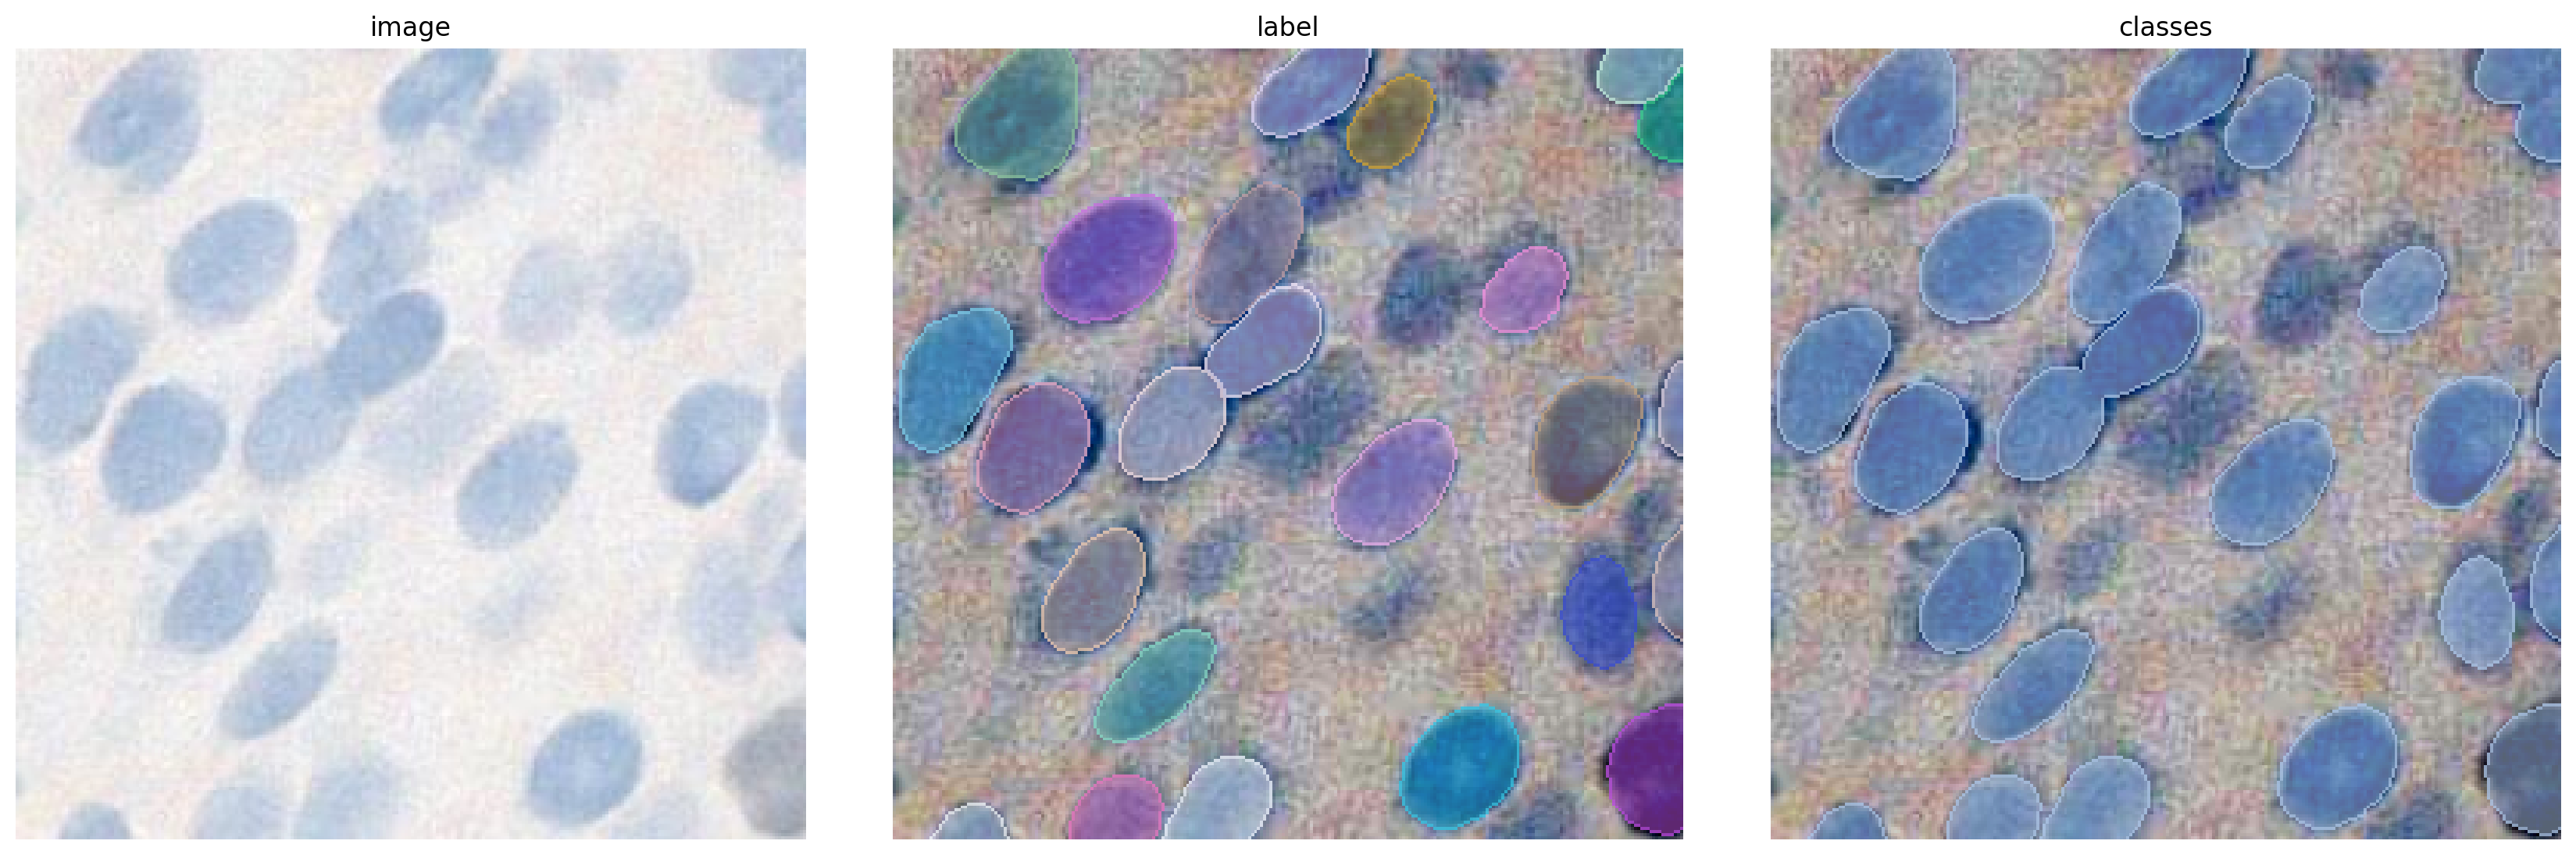

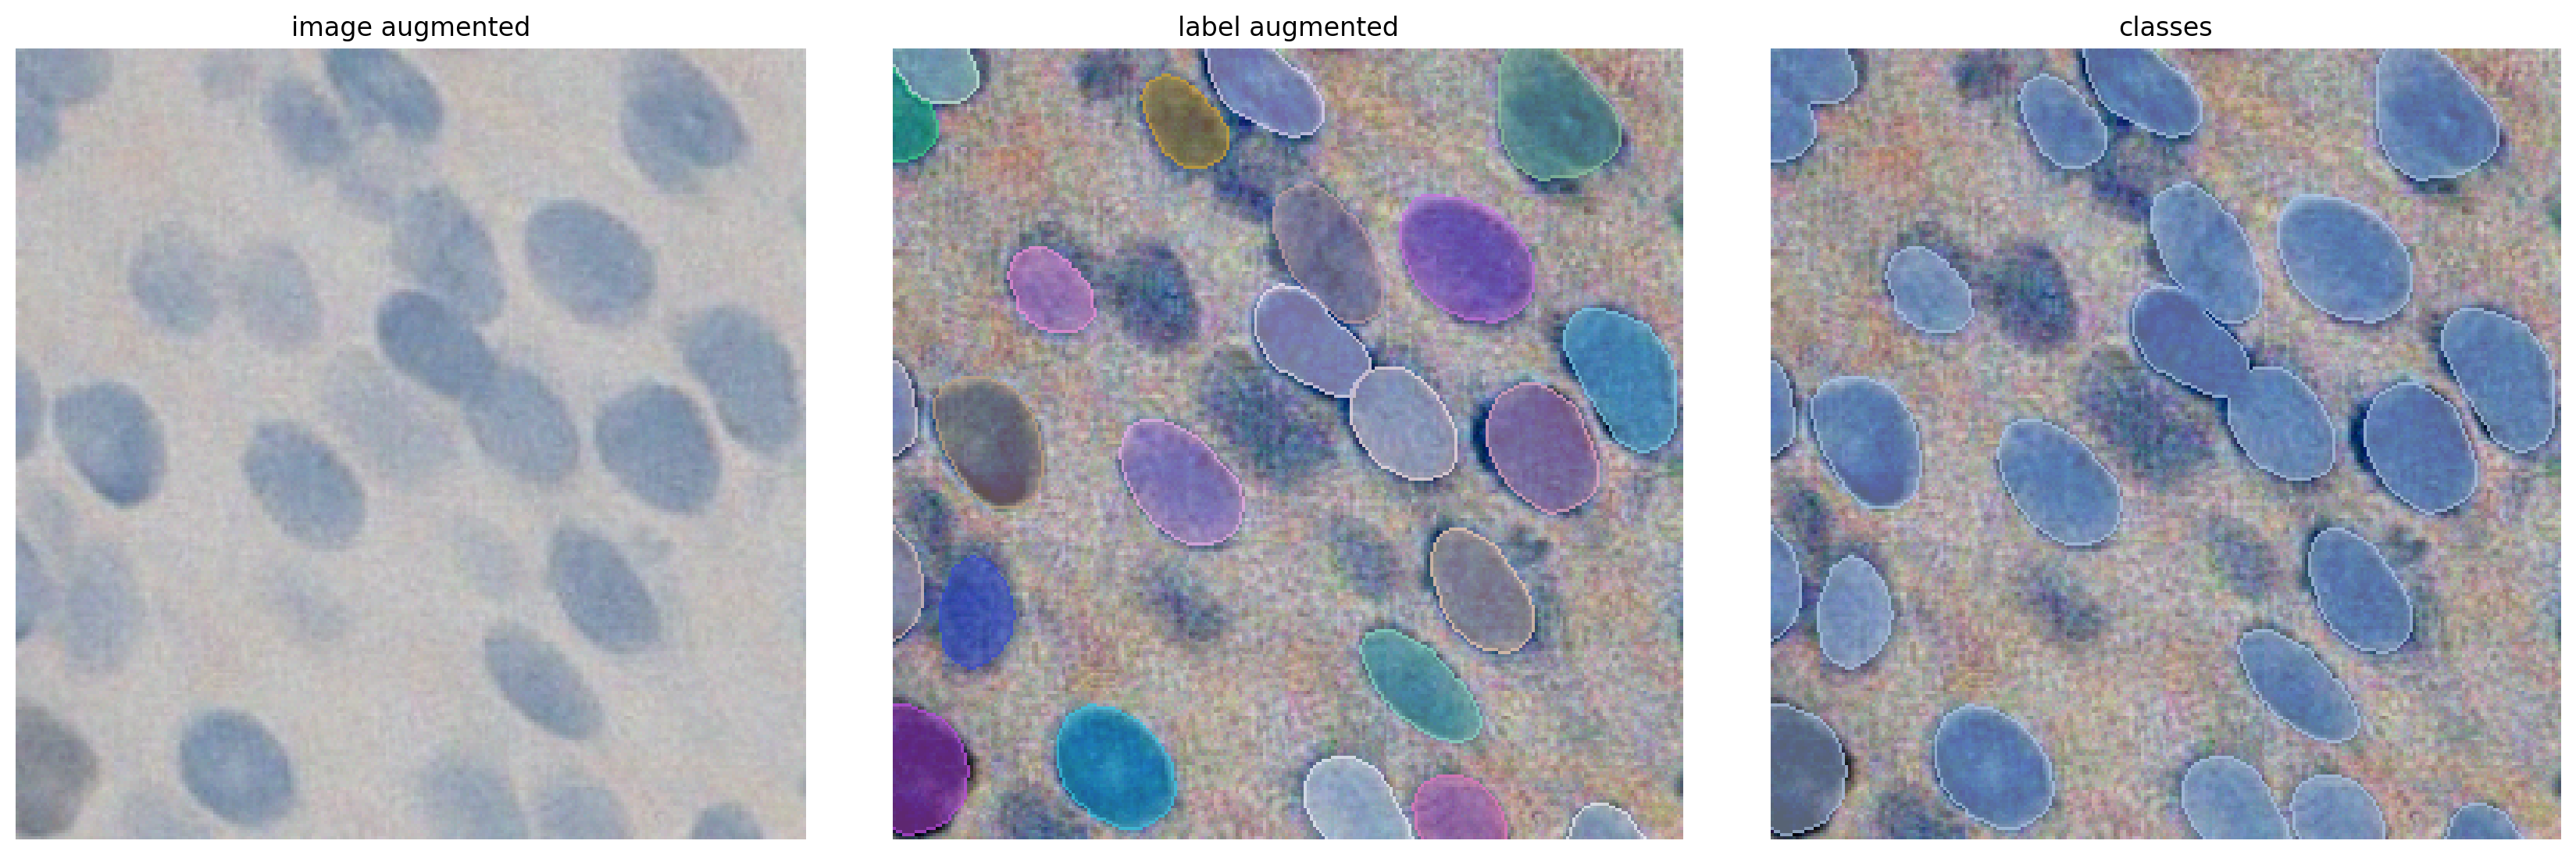

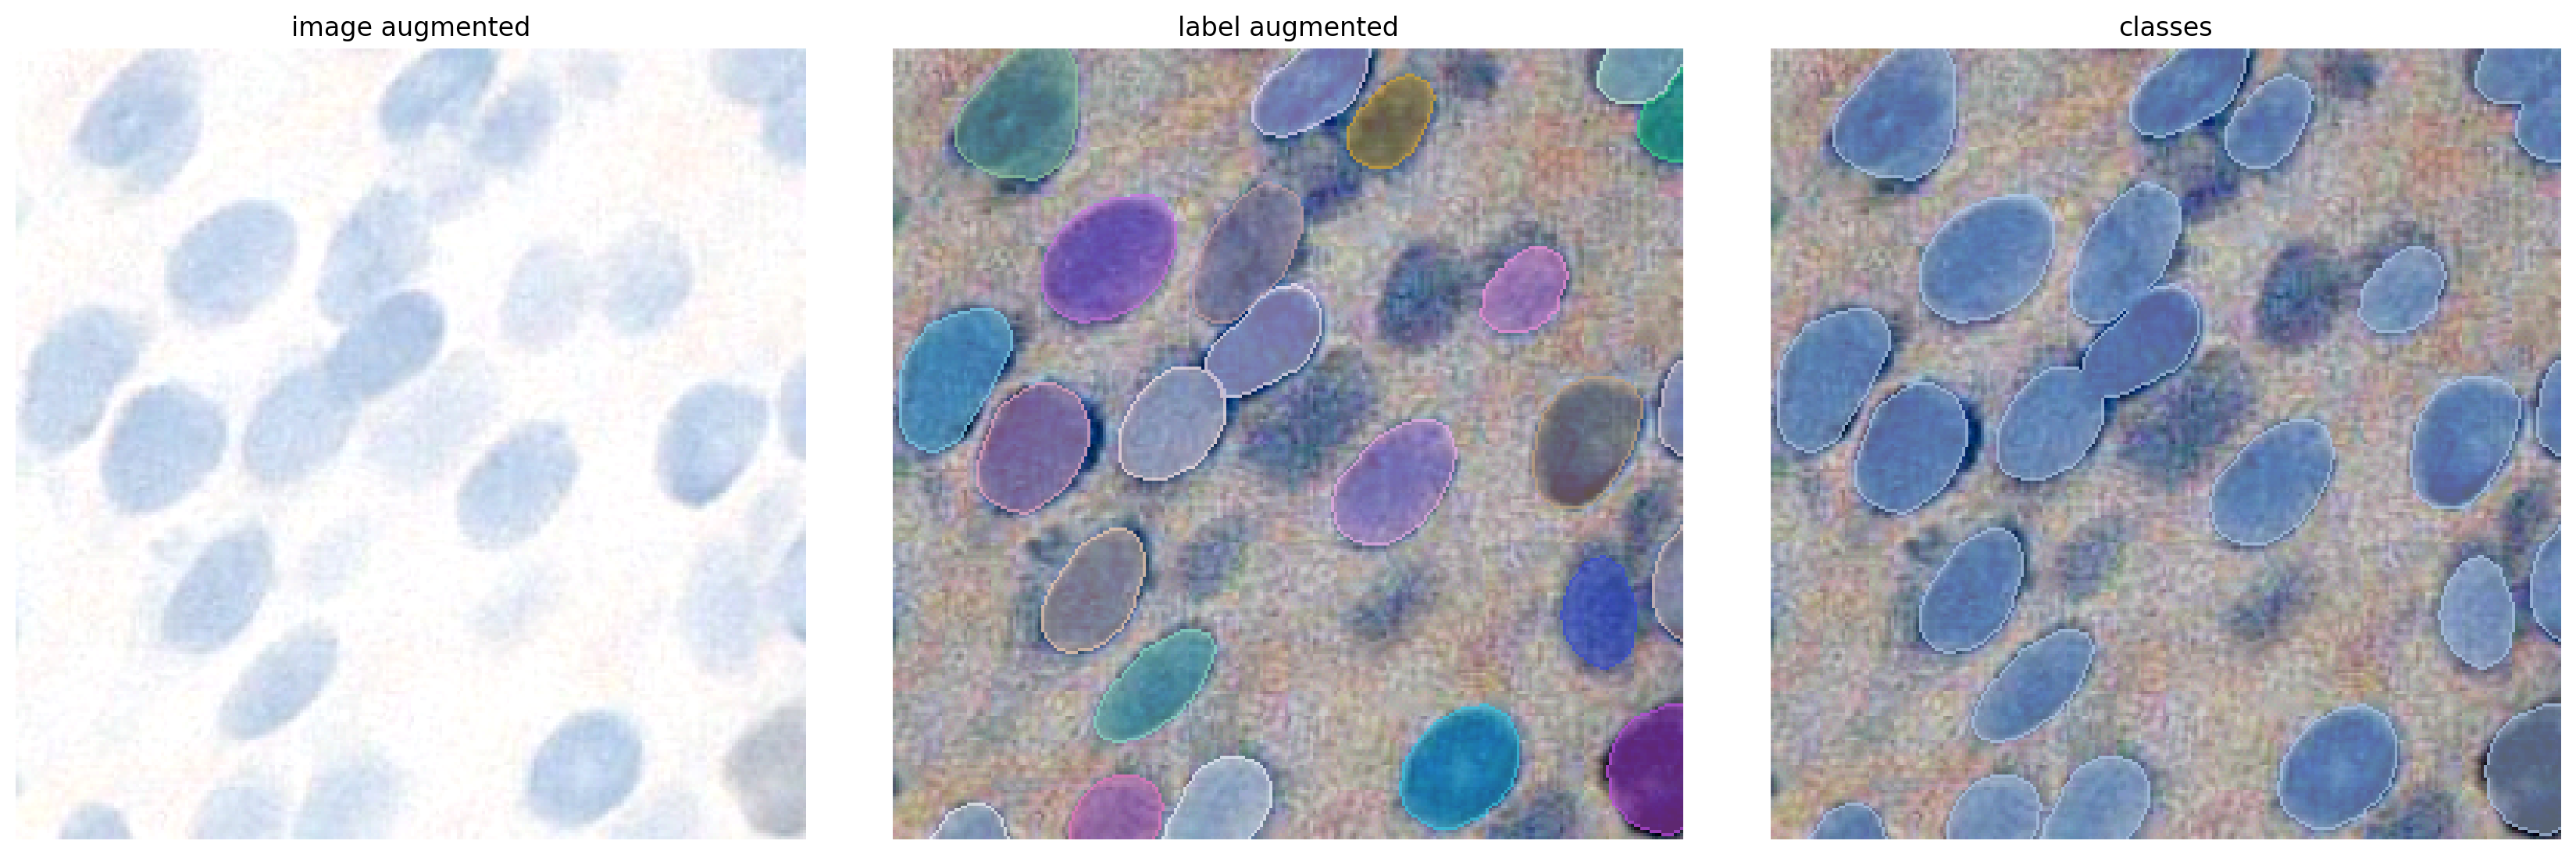

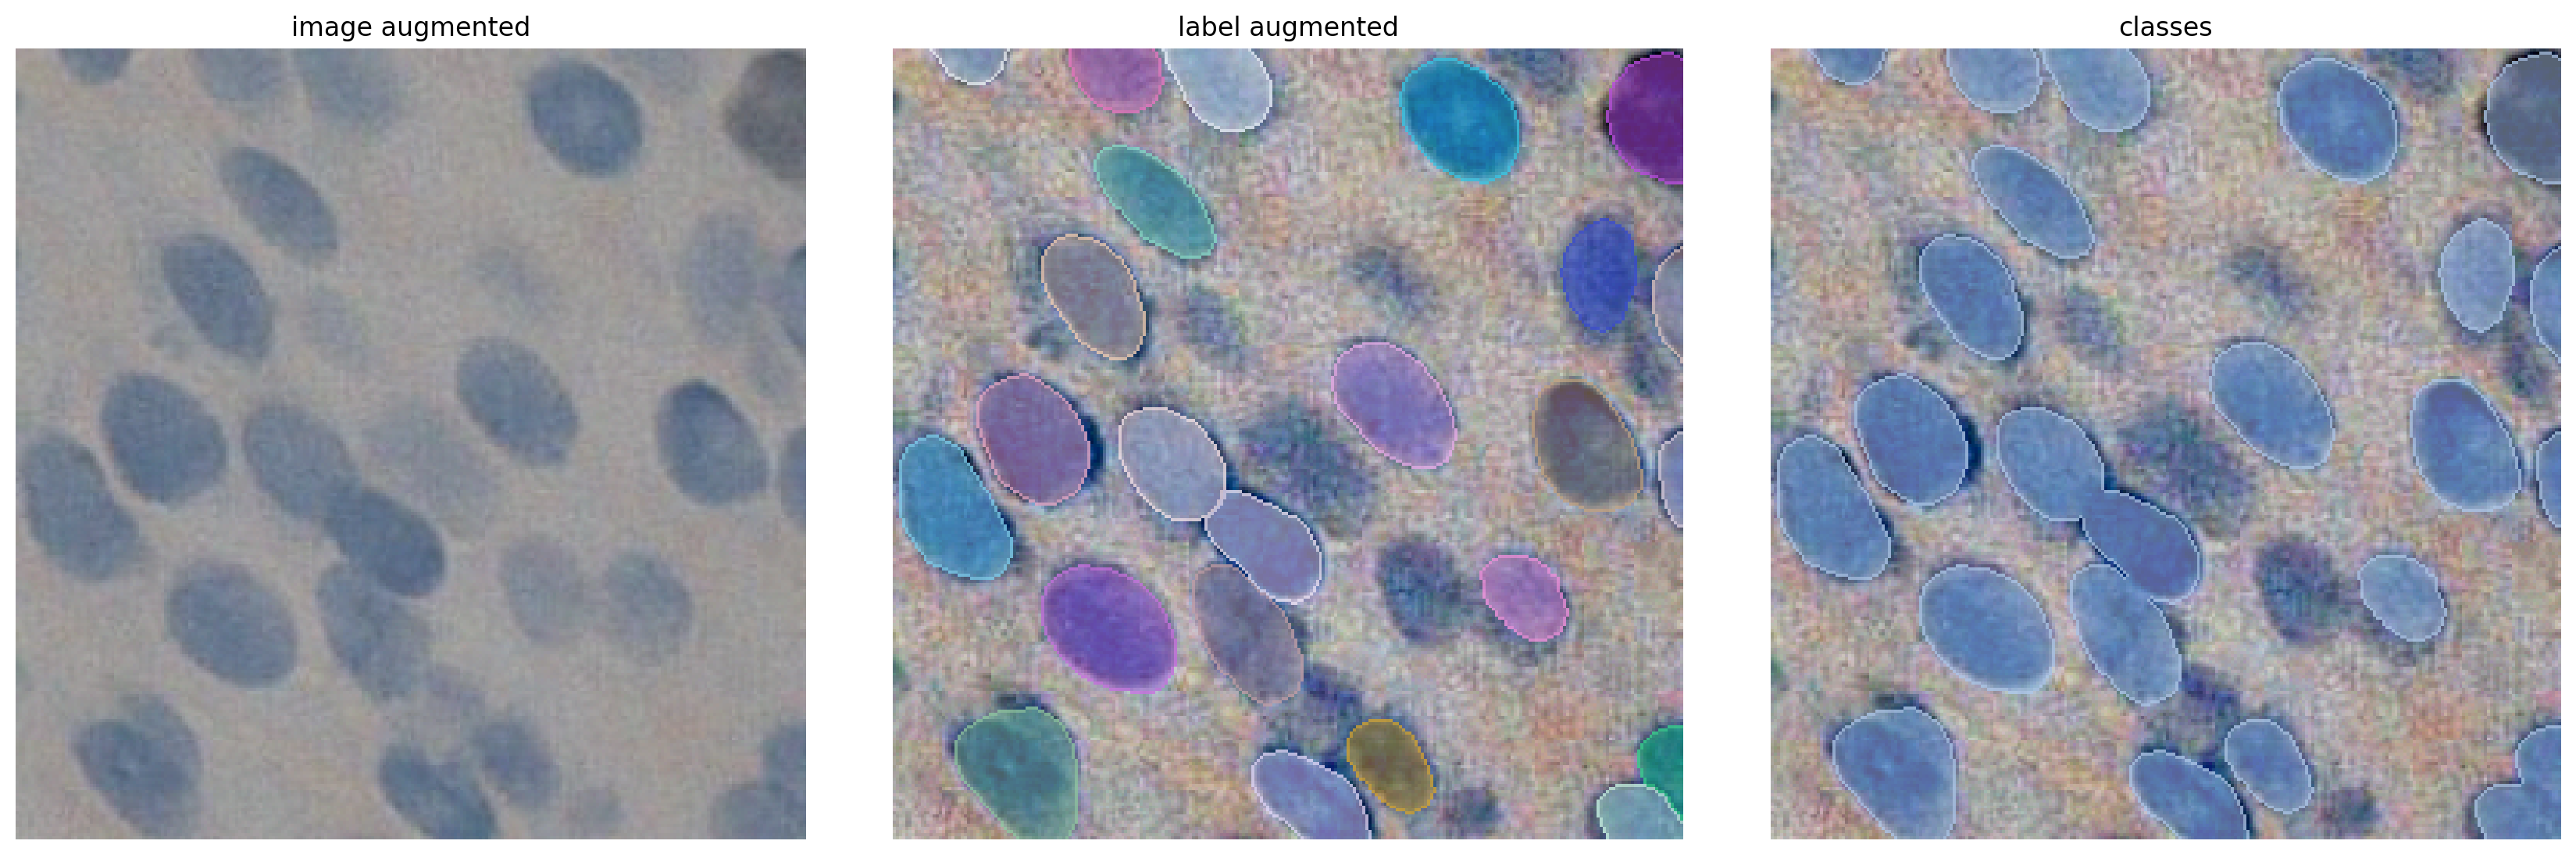

In [13]:
# plot some augmented examples
img, lbl, cls = X_trn[5], Y_trn[5], C_trn[5]
plot_img_label(img,lbl,cls, n_classes=n_classes)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug,lbl_aug,cls, img_title="image augmented", lbl_title="label augmented", n_classes=n_classes)
None;

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [14]:
model.train(X_trn,Y_trn, classes=C_trn, validation_data=(X_val,Y_val,C_val), augmenter=augmenter,
            epochs=200) # 200 epochs seem to be enough for synthetic demo dataset

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

1024/1024 [==============================] - 108s 97ms/step - loss: 2.5133 - prob_loss: 0.3316 - dist_loss: 7.0930 - prob_class_loss: 0.7631 - prob_kld: 0.2029 - dist_relevant_mae: 7.0919 - dist_relevant_mse: 90.5117 - dist_dist_iou_metric: 0.3650 - val_loss: 2.4490 - val_prob_loss: 0.3365 - val_dist_loss: 6.7563 - val_prob_class_loss: 0.7612 - val_prob_kld: 0.2007 - val_dist_relevant_mae: 6.7551 - val_dist_relevant_mse: 83.0965 - val_dist_dist_iou_metric: 0.4066 - lr: 3.0000e-04
Epoch 2/200
1024/1024 [==============================] - 99s 96ms/step - loss: 2.3854 - prob_loss: 0.3303 - dist_loss: 6.5126 - prob_class_loss: 0.7526 - prob_kld: 0.2002 - dist_relevant_mae: 6.5114 - dist_relevant_mse: 76.8167 - dist_dist_iou_metric: 0.4053 - val_loss: 2.4420 - val_prob_loss: 0.3434 - val_dist_loss: 6.6933 - val_prob_class_loss: 0.7599 - val_prob_kld: 0.2076 - val_dist_relevant_mae: 6.6922 - val_dist_relevant_mse: 82.9477 - val_dist_dist_iou_metric: 0.4058 - lr: 3.0000e-04
Epoch 3/200
1024/10

Epoch 13/200
1024/1024 [==============================] - 99s 96ms/step - loss: 1.4623 - prob_loss: 0.2141 - dist_loss: 4.0700 - prob_class_loss: 0.4343 - prob_kld: 0.0845 - dist_relevant_mae: 4.0690 - dist_relevant_mse: 35.6949 - dist_dist_iou_metric: 0.5951 - val_loss: 2.5810 - val_prob_loss: 0.4279 - val_dist_loss: 6.0404 - val_prob_class_loss: 0.9450 - val_prob_kld: 0.2921 - val_dist_relevant_mae: 6.0393 - val_dist_relevant_mse: 77.6659 - val_dist_dist_iou_metric: 0.4496 - lr: 3.0000e-04
Epoch 14/200
1024/1024 [==============================] - 98s 96ms/step - loss: 1.4051 - prob_loss: 0.2061 - dist_loss: 3.9554 - prob_class_loss: 0.4079 - prob_kld: 0.0788 - dist_relevant_mae: 3.9544 - dist_relevant_mse: 34.0857 - dist_dist_iou_metric: 0.6076 - val_loss: 3.1090 - val_prob_loss: 0.5270 - val_dist_loss: 6.7719 - val_prob_class_loss: 1.2277 - val_prob_kld: 0.3911 - val_dist_relevant_mae: 6.7709 - val_dist_relevant_mse: 89.2034 - val_dist_dist_iou_metric: 0.3692 - lr: 3.0000e-04
Epoch 

1024/1024 [==============================] - 99s 97ms/step - loss: 1.2076 - prob_loss: 0.1920 - dist_loss: 3.4251 - prob_class_loss: 0.3306 - prob_kld: 0.0641 - dist_relevant_mae: 3.4241 - dist_relevant_mse: 27.1163 - dist_dist_iou_metric: 0.6495 - val_loss: 2.0051 - val_prob_loss: 0.2543 - val_dist_loss: 5.6858 - val_prob_class_loss: 0.6137 - val_prob_kld: 0.1184 - val_dist_relevant_mae: 5.6850 - val_dist_relevant_mse: 75.1482 - val_dist_dist_iou_metric: 0.4558 - lr: 3.0000e-04
Epoch 25/200
1024/1024 [==============================] - 99s 96ms/step - loss: 1.1863 - prob_loss: 0.1938 - dist_loss: 3.3326 - prob_class_loss: 0.3260 - prob_kld: 0.0644 - dist_relevant_mae: 3.3316 - dist_relevant_mse: 25.6030 - dist_dist_iou_metric: 0.6551 - val_loss: 2.1895 - val_prob_loss: 0.3196 - val_dist_loss: 5.4940 - val_prob_class_loss: 0.7711 - val_prob_kld: 0.1837 - val_dist_relevant_mae: 5.4931 - val_dist_relevant_mse: 65.4261 - val_dist_dist_iou_metric: 0.4721 - lr: 3.0000e-04
Epoch 26/200
1024/1

1024/1024 [==============================] - 99s 97ms/step - loss: 1.0834 - prob_loss: 0.1868 - dist_loss: 2.9989 - prob_class_loss: 0.2968 - prob_kld: 0.0566 - dist_relevant_mae: 2.9980 - dist_relevant_mse: 21.3401 - dist_dist_iou_metric: 0.6833 - val_loss: 2.2613 - val_prob_loss: 0.3320 - val_dist_loss: 5.4381 - val_prob_class_loss: 0.8417 - val_prob_kld: 0.1962 - val_dist_relevant_mae: 5.4373 - val_dist_relevant_mse: 68.0285 - val_dist_dist_iou_metric: 0.4739 - lr: 3.0000e-04
Epoch 36/200
1024/1024 [==============================] - 99s 96ms/step - loss: 1.0803 - prob_loss: 0.1866 - dist_loss: 2.9662 - prob_class_loss: 0.3005 - prob_kld: 0.0569 - dist_relevant_mae: 2.9653 - dist_relevant_mse: 21.3518 - dist_dist_iou_metric: 0.6867 - val_loss: 2.3716 - val_prob_loss: 0.3598 - val_dist_loss: 5.5480 - val_prob_class_loss: 0.9022 - val_prob_kld: 0.2240 - val_dist_relevant_mae: 5.5471 - val_dist_relevant_mse: 70.0801 - val_dist_dist_iou_metric: 0.4650 - lr: 3.0000e-04
Epoch 37/200
1024/1

1024/1024 [==============================] - 99s 96ms/step - loss: 1.0195 - prob_loss: 0.1833 - dist_loss: 2.7573 - prob_class_loss: 0.2847 - prob_kld: 0.0523 - dist_relevant_mae: 2.7563 - dist_relevant_mse: 18.6905 - dist_dist_iou_metric: 0.7075 - val_loss: 2.4250 - val_prob_loss: 0.3662 - val_dist_loss: 5.4503 - val_prob_class_loss: 0.9687 - val_prob_kld: 0.2304 - val_dist_relevant_mae: 5.4494 - val_dist_relevant_mse: 66.7431 - val_dist_dist_iou_metric: 0.4703 - lr: 3.0000e-04
Epoch 47/200
1024/1024 [==============================] - 98s 96ms/step - loss: 1.0011 - prob_loss: 0.1791 - dist_loss: 2.7269 - prob_class_loss: 0.2767 - prob_kld: 0.0514 - dist_relevant_mae: 2.7260 - dist_relevant_mse: 18.1306 - dist_dist_iou_metric: 0.7073 - val_loss: 2.6212 - val_prob_loss: 0.4026 - val_dist_loss: 5.9296 - val_prob_class_loss: 1.0326 - val_prob_kld: 0.2668 - val_dist_relevant_mae: 5.9286 - val_dist_relevant_mse: 74.7561 - val_dist_dist_iou_metric: 0.4382 - lr: 3.0000e-04
Epoch 48/200
1024/1

1024/1024 [==============================] - 99s 96ms/step - loss: 0.9660 - prob_loss: 0.1791 - dist_loss: 2.5931 - prob_class_loss: 0.2683 - prob_kld: 0.0484 - dist_relevant_mae: 2.5922 - dist_relevant_mse: 16.9931 - dist_dist_iou_metric: 0.7243 - val_loss: 2.6074 - val_prob_loss: 0.4104 - val_dist_loss: 5.7181 - val_prob_class_loss: 1.0533 - val_prob_kld: 0.2745 - val_dist_relevant_mae: 5.7172 - val_dist_relevant_mse: 73.9931 - val_dist_dist_iou_metric: 0.4514 - lr: 3.0000e-04
Epoch 58/200
1024/1024 [==============================] - 99s 96ms/step - loss: 0.9452 - prob_loss: 0.1764 - dist_loss: 2.5322 - prob_class_loss: 0.2624 - prob_kld: 0.0472 - dist_relevant_mae: 2.5313 - dist_relevant_mse: 16.0594 - dist_dist_iou_metric: 0.7245 - val_loss: 2.6203 - val_prob_loss: 0.4034 - val_dist_loss: 5.7143 - val_prob_class_loss: 1.0740 - val_prob_kld: 0.2675 - val_dist_relevant_mae: 5.7134 - val_dist_relevant_mse: 74.5607 - val_dist_dist_iou_metric: 0.4596 - lr: 3.0000e-04
Epoch 59/200
1024/1

1024/1024 [==============================] - 98s 96ms/step - loss: 0.9062 - prob_loss: 0.1714 - dist_loss: 2.4136 - prob_class_loss: 0.2521 - prob_kld: 0.0443 - dist_relevant_mae: 2.4128 - dist_relevant_mse: 14.5203 - dist_dist_iou_metric: 0.7344 - val_loss: 2.7232 - val_prob_loss: 0.4223 - val_dist_loss: 5.8567 - val_prob_class_loss: 1.1295 - val_prob_kld: 0.2865 - val_dist_relevant_mae: 5.8560 - val_dist_relevant_mse: 80.2647 - val_dist_dist_iou_metric: 0.4407 - lr: 3.0000e-04
Epoch 69/200
1024/1024 [==============================] - 99s 97ms/step - loss: 0.8995 - prob_loss: 0.1740 - dist_loss: 2.3893 - prob_class_loss: 0.2477 - prob_kld: 0.0442 - dist_relevant_mae: 2.3884 - dist_relevant_mse: 14.4062 - dist_dist_iou_metric: 0.7407 - val_loss: 2.5250 - val_prob_loss: 0.3833 - val_dist_loss: 5.6277 - val_prob_class_loss: 1.0162 - val_prob_kld: 0.2474 - val_dist_relevant_mae: 5.6269 - val_dist_relevant_mse: 72.6485 - val_dist_dist_iou_metric: 0.4513 - lr: 3.0000e-04
Epoch 70/200
1024/1

1024/1024 [==============================] - 98s 96ms/step - loss: 0.8578 - prob_loss: 0.1709 - dist_loss: 2.2483 - prob_class_loss: 0.2373 - prob_kld: 0.0412 - dist_relevant_mae: 2.2474 - dist_relevant_mse: 12.8138 - dist_dist_iou_metric: 0.7524 - val_loss: 2.3595 - val_prob_loss: 0.3535 - val_dist_loss: 5.3232 - val_prob_class_loss: 0.9413 - val_prob_kld: 0.2176 - val_dist_relevant_mae: 5.3223 - val_dist_relevant_mse: 65.5943 - val_dist_dist_iou_metric: 0.4822 - lr: 3.0000e-04
Epoch 80/200
1024/1024 [==============================] - 98s 96ms/step - loss: 0.8582 - prob_loss: 0.1696 - dist_loss: 2.2593 - prob_class_loss: 0.2367 - prob_kld: 0.0411 - dist_relevant_mae: 2.2585 - dist_relevant_mse: 12.7791 - dist_dist_iou_metric: 0.7503 - val_loss: 2.6385 - val_prob_loss: 0.4136 - val_dist_loss: 5.5878 - val_prob_class_loss: 1.1074 - val_prob_kld: 0.2777 - val_dist_relevant_mae: 5.5871 - val_dist_relevant_mse: 74.6526 - val_dist_dist_iou_metric: 0.4616 - lr: 3.0000e-04
Epoch 81/200
1024/1

1024/1024 [==============================] - 99s 96ms/step - loss: 0.8181 - prob_loss: 0.1668 - dist_loss: 2.1312 - prob_class_loss: 0.2250 - prob_kld: 0.0382 - dist_relevant_mae: 2.1303 - dist_relevant_mse: 11.6375 - dist_dist_iou_metric: 0.7626 - val_loss: 2.4840 - val_prob_loss: 0.3943 - val_dist_loss: 5.2502 - val_prob_class_loss: 1.0397 - val_prob_kld: 0.2583 - val_dist_relevant_mae: 5.2494 - val_dist_relevant_mse: 69.9063 - val_dist_dist_iou_metric: 0.4996 - lr: 3.0000e-04
Epoch 91/200
1024/1024 [==============================] - ETA: 0s - loss: 0.8246 - prob_loss: 0.1691 - dist_loss: 2.1486 - prob_class_loss: 0.2258 - prob_kld: 0.0384 - dist_relevant_mae: 2.1478 - dist_relevant_mse: 11.6945 - dist_dist_iou_metric: 0.7624
Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
1024/1024 [==============================] - 98s 96ms/step - loss: 0.8246 - prob_loss: 0.1691 - dist_loss: 2.1486 - prob_class_loss: 0.2258 - prob_kld: 0.0384 - dist_relevant_mae: 2.147

Epoch 101/200
1024/1024 [==============================] - 98s 96ms/step - loss: 0.7250 - prob_loss: 0.1608 - dist_loss: 1.8483 - prob_class_loss: 0.1945 - prob_kld: 0.0327 - dist_relevant_mae: 1.8475 - dist_relevant_mse: 9.2846 - dist_dist_iou_metric: 0.7895 - val_loss: 2.7436 - val_prob_loss: 0.4375 - val_dist_loss: 5.5880 - val_prob_class_loss: 1.1884 - val_prob_kld: 0.3016 - val_dist_relevant_mae: 5.5873 - val_dist_relevant_mse: 76.3260 - val_dist_dist_iou_metric: 0.4687 - lr: 1.5000e-04
Epoch 102/200
1024/1024 [==============================] - 99s 97ms/step - loss: 0.7279 - prob_loss: 0.1639 - dist_loss: 1.8391 - prob_class_loss: 0.1962 - prob_kld: 0.0330 - dist_relevant_mae: 1.8383 - dist_relevant_mse: 9.2515 - dist_dist_iou_metric: 0.7916 - val_loss: 2.5327 - val_prob_loss: 0.4103 - val_dist_loss: 5.3028 - val_prob_class_loss: 1.0618 - val_prob_kld: 0.2744 - val_dist_relevant_mae: 5.3020 - val_dist_relevant_mse: 71.8930 - val_dist_dist_iou_metric: 0.4971 - lr: 1.5000e-04
Epoch 

1024/1024 [==============================] - 98s 96ms/step - loss: 0.6971 - prob_loss: 0.1602 - dist_loss: 1.7629 - prob_class_loss: 0.1843 - prob_kld: 0.0304 - dist_relevant_mae: 1.7621 - dist_relevant_mse: 8.6422 - dist_dist_iou_metric: 0.8005 - val_loss: 2.6346 - val_prob_loss: 0.4210 - val_dist_loss: 5.4066 - val_prob_class_loss: 1.1323 - val_prob_kld: 0.2851 - val_dist_relevant_mae: 5.4059 - val_dist_relevant_mse: 72.4216 - val_dist_dist_iou_metric: 0.4855 - lr: 1.5000e-04
Epoch 113/200
1024/1024 [==============================] - 98s 96ms/step - loss: 0.6861 - prob_loss: 0.1584 - dist_loss: 1.7315 - prob_class_loss: 0.1815 - prob_kld: 0.0301 - dist_relevant_mae: 1.7307 - dist_relevant_mse: 8.2308 - dist_dist_iou_metric: 0.8001 - val_loss: 2.9002 - val_prob_loss: 0.4782 - val_dist_loss: 5.7604 - val_prob_class_loss: 1.2699 - val_prob_kld: 0.3423 - val_dist_relevant_mae: 5.7597 - val_dist_relevant_mse: 81.5433 - val_dist_dist_iou_metric: 0.4598 - lr: 1.5000e-04
Epoch 114/200
1024/1

1024/1024 [==============================] - 98s 96ms/step - loss: 0.6626 - prob_loss: 0.1567 - dist_loss: 1.6768 - prob_class_loss: 0.1705 - prob_kld: 0.0283 - dist_relevant_mae: 1.6761 - dist_relevant_mse: 7.6980 - dist_dist_iou_metric: 0.8072 - val_loss: 2.9737 - val_prob_loss: 0.4853 - val_dist_loss: 5.7284 - val_prob_class_loss: 1.3427 - val_prob_kld: 0.3493 - val_dist_relevant_mae: 5.7278 - val_dist_relevant_mse: 79.5810 - val_dist_dist_iou_metric: 0.4607 - lr: 1.5000e-04
Epoch 124/200
1024/1024 [==============================] - 98s 96ms/step - loss: 0.6688 - prob_loss: 0.1602 - dist_loss: 1.6811 - prob_class_loss: 0.1724 - prob_kld: 0.0292 - dist_relevant_mae: 1.6803 - dist_relevant_mse: 7.8316 - dist_dist_iou_metric: 0.8049 - val_loss: 3.0569 - val_prob_loss: 0.5253 - val_dist_loss: 5.8166 - val_prob_class_loss: 1.3683 - val_prob_kld: 0.3892 - val_dist_relevant_mae: 5.8159 - val_dist_relevant_mse: 81.5332 - val_dist_dist_iou_metric: 0.4517 - lr: 1.5000e-04
Epoch 125/200
1024/1

Epoch 134/200
1024/1024 [==============================] - 98s 96ms/step - loss: 0.6060 - prob_loss: 0.1525 - dist_loss: 1.5294 - prob_class_loss: 0.1476 - prob_kld: 0.0254 - dist_relevant_mae: 1.5287 - dist_relevant_mse: 6.6984 - dist_dist_iou_metric: 0.8216 - val_loss: 3.7230 - val_prob_loss: 0.6298 - val_dist_loss: 6.7078 - val_prob_class_loss: 1.7516 - val_prob_kld: 0.4931 - val_dist_relevant_mae: 6.7073 - val_dist_relevant_mse: 101.4657 - val_dist_dist_iou_metric: 0.3918 - lr: 7.5000e-05
Epoch 135/200
1024/1024 [==============================] - 99s 96ms/step - loss: 0.6118 - prob_loss: 0.1550 - dist_loss: 1.5262 - prob_class_loss: 0.1515 - prob_kld: 0.0252 - dist_relevant_mae: 1.5255 - dist_relevant_mse: 6.6983 - dist_dist_iou_metric: 0.8212 - val_loss: 3.4355 - val_prob_loss: 0.5810 - val_dist_loss: 6.1957 - val_prob_class_loss: 1.6154 - val_prob_kld: 0.4444 - val_dist_relevant_mae: 6.1951 - val_dist_relevant_mse: 91.0278 - val_dist_dist_iou_metric: 0.4306 - lr: 7.5000e-05
Epoch

1024/1024 [==============================] - 99s 96ms/step - loss: 0.5955 - prob_loss: 0.1554 - dist_loss: 1.4775 - prob_class_loss: 0.1446 - prob_kld: 0.0251 - dist_relevant_mae: 1.4768 - dist_relevant_mse: 6.3236 - dist_dist_iou_metric: 0.8259 - val_loss: 3.4616 - val_prob_loss: 0.5806 - val_dist_loss: 6.3230 - val_prob_class_loss: 1.6164 - val_prob_kld: 0.4443 - val_dist_relevant_mae: 6.3224 - val_dist_relevant_mse: 92.4658 - val_dist_dist_iou_metric: 0.4164 - lr: 7.5000e-05
Epoch 146/200
1024/1024 [==============================] - 98s 96ms/step - loss: 0.5874 - prob_loss: 0.1530 - dist_loss: 1.4710 - prob_class_loss: 0.1401 - prob_kld: 0.0240 - dist_relevant_mae: 1.4703 - dist_relevant_mse: 6.4086 - dist_dist_iou_metric: 0.8250 - val_loss: 3.6732 - val_prob_loss: 0.6205 - val_dist_loss: 6.7169 - val_prob_class_loss: 1.7093 - val_prob_kld: 0.4841 - val_dist_relevant_mae: 6.7164 - val_dist_relevant_mse: 100.6466 - val_dist_dist_iou_metric: 0.3891 - lr: 7.5000e-05
Epoch 147/200
1024/

1024/1024 [==============================] - 98s 96ms/step - loss: 0.5642 - prob_loss: 0.1509 - dist_loss: 1.4146 - prob_class_loss: 0.1303 - prob_kld: 0.0226 - dist_relevant_mae: 1.4139 - dist_relevant_mse: 5.8611 - dist_dist_iou_metric: 0.8317 - val_loss: 3.4118 - val_prob_loss: 0.5688 - val_dist_loss: 6.2637 - val_prob_class_loss: 1.5902 - val_prob_kld: 0.4325 - val_dist_relevant_mae: 6.2631 - val_dist_relevant_mse: 90.3759 - val_dist_dist_iou_metric: 0.4220 - lr: 7.5000e-05
Epoch 157/200
1024/1024 [==============================] - 99s 96ms/step - loss: 0.5690 - prob_loss: 0.1540 - dist_loss: 1.4167 - prob_class_loss: 0.1316 - prob_kld: 0.0230 - dist_relevant_mae: 1.4161 - dist_relevant_mse: 5.9871 - dist_dist_iou_metric: 0.8329 - val_loss: 3.5703 - val_prob_loss: 0.5811 - val_dist_loss: 6.3919 - val_prob_class_loss: 1.7107 - val_prob_kld: 0.4446 - val_dist_relevant_mae: 6.3913 - val_dist_relevant_mse: 92.5687 - val_dist_dist_iou_metric: 0.4122 - lr: 7.5000e-05
Epoch 158/200
1024/1

1024/1024 [==============================] - 99s 96ms/step - loss: 0.5469 - prob_loss: 0.1500 - dist_loss: 1.3738 - prob_class_loss: 0.1221 - prob_kld: 0.0214 - dist_relevant_mae: 1.3731 - dist_relevant_mse: 5.6141 - dist_dist_iou_metric: 0.8361 - val_loss: 3.5666 - val_prob_loss: 0.5787 - val_dist_loss: 6.2825 - val_prob_class_loss: 1.7314 - val_prob_kld: 0.4423 - val_dist_relevant_mae: 6.2819 - val_dist_relevant_mse: 90.8285 - val_dist_dist_iou_metric: 0.4210 - lr: 7.5000e-05
Epoch 168/200
1024/1024 [==============================] - 99s 97ms/step - loss: 0.5478 - prob_loss: 0.1506 - dist_loss: 1.3729 - prob_class_loss: 0.1227 - prob_kld: 0.0217 - dist_relevant_mae: 1.3722 - dist_relevant_mse: 5.6650 - dist_dist_iou_metric: 0.8362 - val_loss: 3.6727 - val_prob_loss: 0.6041 - val_dist_loss: 6.4863 - val_prob_class_loss: 1.7713 - val_prob_kld: 0.4673 - val_dist_relevant_mae: 6.4857 - val_dist_relevant_mse: 94.5796 - val_dist_dist_iou_metric: 0.4043 - lr: 7.5000e-05
Epoch 169/200
1024/1

Epoch 178/200
1024/1024 [==============================] - 99s 97ms/step - loss: 0.5238 - prob_loss: 0.1506 - dist_loss: 1.3037 - prob_class_loss: 0.1124 - prob_kld: 0.0204 - dist_relevant_mae: 1.3030 - dist_relevant_mse: 5.2546 - dist_dist_iou_metric: 0.8446 - val_loss: 3.7318 - val_prob_loss: 0.6050 - val_dist_loss: 6.4637 - val_prob_class_loss: 1.8341 - val_prob_kld: 0.4682 - val_dist_relevant_mae: 6.4631 - val_dist_relevant_mse: 94.3047 - val_dist_dist_iou_metric: 0.4092 - lr: 3.7500e-05
Epoch 179/200
1024/1024 [==============================] - 98s 96ms/step - loss: 0.5223 - prob_loss: 0.1491 - dist_loss: 1.3073 - prob_class_loss: 0.1118 - prob_kld: 0.0203 - dist_relevant_mae: 1.3066 - dist_relevant_mse: 5.3005 - dist_dist_iou_metric: 0.8426 - val_loss: 3.8368 - val_prob_loss: 0.6357 - val_dist_loss: 6.4344 - val_prob_class_loss: 1.9142 - val_prob_kld: 0.4978 - val_dist_relevant_mae: 6.4338 - val_dist_relevant_mse: 93.8889 - val_dist_dist_iou_metric: 0.4097 - lr: 3.7500e-05
Epoch 

1024/1024 [==============================] - 99s 96ms/step - loss: 0.5082 - prob_loss: 0.1487 - dist_loss: 1.2654 - prob_class_loss: 0.1064 - prob_kld: 0.0197 - dist_relevant_mae: 1.2648 - dist_relevant_mse: 4.9874 - dist_dist_iou_metric: 0.8469 - val_loss: 3.7196 - val_prob_loss: 0.5982 - val_dist_loss: 6.4754 - val_prob_class_loss: 1.8263 - val_prob_kld: 0.4613 - val_dist_relevant_mae: 6.4748 - val_dist_relevant_mse: 94.2162 - val_dist_dist_iou_metric: 0.4081 - lr: 3.7500e-05
Epoch 190/200
1024/1024 [==============================] - 99s 96ms/step - loss: 0.5101 - prob_loss: 0.1500 - dist_loss: 1.2692 - prob_class_loss: 0.1063 - prob_kld: 0.0197 - dist_relevant_mae: 1.2686 - dist_relevant_mse: 5.0127 - dist_dist_iou_metric: 0.8474 - val_loss: 3.5455 - val_prob_loss: 0.5643 - val_dist_loss: 6.0882 - val_prob_class_loss: 1.7636 - val_prob_kld: 0.4270 - val_dist_relevant_mae: 6.0876 - val_dist_relevant_mse: 86.8765 - val_dist_dist_iou_metric: 0.4410 - lr: 3.7500e-05
Epoch 191/200
1024/1

1024/1024 [==============================] - 98s 95ms/step - loss: 0.5023 - prob_loss: 0.1493 - dist_loss: 1.2541 - prob_class_loss: 0.1022 - prob_kld: 0.0191 - dist_relevant_mae: 1.2535 - dist_relevant_mse: 4.9974 - dist_dist_iou_metric: 0.8496 - val_loss: 4.0527 - val_prob_loss: 0.6544 - val_dist_loss: 6.9672 - val_prob_class_loss: 2.0049 - val_prob_kld: 0.5173 - val_dist_relevant_mae: 6.9666 - val_dist_relevant_mse: 104.4859 - val_dist_dist_iou_metric: 0.3711 - lr: 3.7500e-05

Loading network weights from 'weights_best.h5'.
